In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])
import pickle

In [83]:
def concatenate_parquet_files(path):
    """
    Concatenate all parquet files in the given directory into a single DataFrame.

    Parameters:
    path (str): The directory containing the parquet files.

    Returns:
    pd.DataFrame: The concatenated DataFrame.
    """
    # List all files in the directory
    files = [f for f in os.listdir(path) if f.endswith('.parquet')]
    
    # Read and concatenate all parquet files
    dataframes = [pd.read_parquet(os.path.join(path, file)) for file in files]
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_df

In [84]:
path_zee = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/zee_deriv2/single'
path_ttbar = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/ttbar2/single'

data_ttbar = concatenate_parquet_files(path_ttbar)
data_zeederiv = concatenate_parquet_files(path_zee)

print(f'TTbar data shape: {data_ttbar.shape}')
print(f'Zee deriv data shape: {data_zeederiv.shape}')


TTbar data shape: (2705661, 90)
Zee deriv data shape: (2077252, 90)


In [85]:
data_zeederiv['el1_GSFTrack_POverq'] = np.abs(data_zeederiv['el1_GSFTrack_qOverP'])**(-1)
data_zeederiv['el1_InDetTrack_POverq'] = np.abs(data_zeederiv['el1_InDetTrack_qOverP'])**(-1)

data_ttbar['el1_GSFTrack_POverq'] = np.abs(data_ttbar['el1_GSFTrack_qOverP'])**(-1)
data_ttbar['el1_InDetTrack_POverq'] = np.abs(data_ttbar['el1_InDetTrack_qOverP'])**(-1)
# ['el1_GSFTrack_POverq', 'el1_InDetTrack_POverq']

mass is in MeV

In [86]:
E_ttbar_atlas = np.sqrt( data_ttbar['el1_pt']**2 * np.cosh(data_ttbar['el1_eta'])**2 + (data_ttbar['el1_m'])**2 )
E_zeederiv_atlas = np.sqrt(data_zeederiv['el1_pt']**2 * np.cosh(data_zeederiv['el1_eta'])**2 + (data_zeederiv['el1_m'])**2)

print(E_ttbar_atlas.shape)
print(E_zeederiv_atlas.shape)

data_ttbar['ATLAS_E'] = E_ttbar_atlas
data_zeederiv['ATLAS_E'] = E_zeederiv_atlas

(2705661,)
(2077252,)


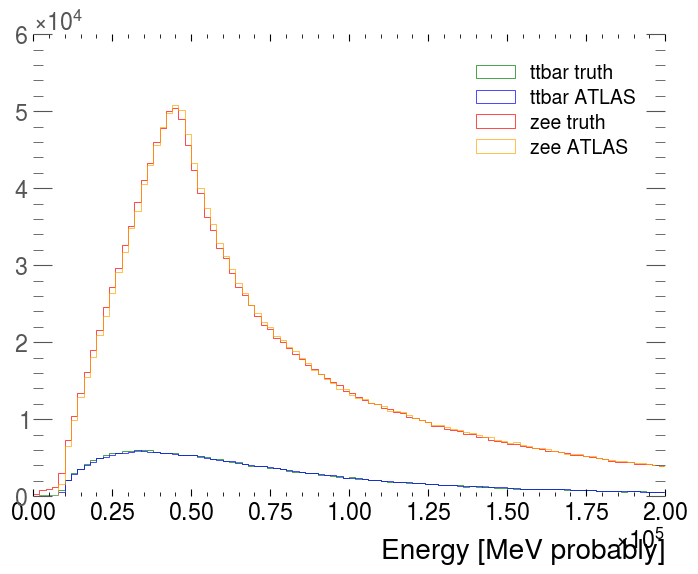

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(data_ttbar[data_ttbar['el1_truthType'] == 2]['el1_truth_E'],range=(0,200000), bins=100, histtype='step', label='ttbar truth', color='green')
ax.hist(data_ttbar[data_ttbar['el1_truthType'] == 2]['ATLAS_E'],range=(0,200000), bins=100, histtype='step', label='ttbar ATLAS', color='blue')
ax.hist(data_zeederiv[data_zeederiv['el1_truthType'] == 2]['el1_truth_E'],range=(0,200000), bins=100, histtype='step', label='zee truth', color='red')
ax.hist(data_zeederiv[data_zeederiv['el1_truthType'] == 2]['ATLAS_E'],range=(0,200000), bins=100, histtype='step', label='zee ATLAS', color='orange')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('Energy [MeV probably]')
ax.legend()

TTbar data shape: (2705661, 78)
Zee deriv data shape: (386770, 78)

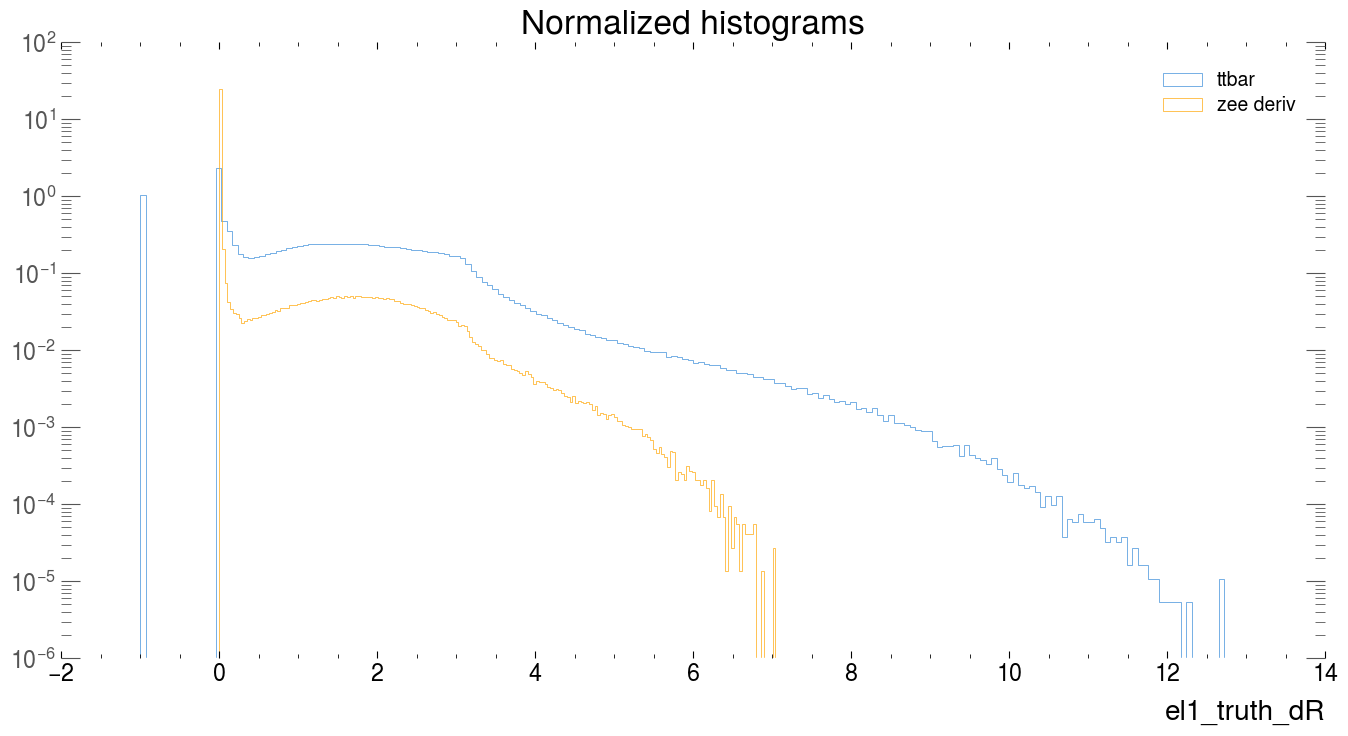

In [88]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(data_ttbar['el1_truth_dR'],histtype='step',density=True,bins=200, label='ttbar')
ax.hist(data_zeederiv['el1_truth_dR'],histtype='step',density=True,bins=200, label='zee deriv')
ax.set_title('Normalized histograms')
ax.set_xlabel('el1_truth_dR')
ax.set_yscale('log')
ax.legend()

In [89]:
print(len(data_ttbar[data_ttbar['el1_truth_dR']==-1])/len(data_ttbar))

0.07214651059389923


In [90]:
cut_data_ttbar = data_ttbar[data_ttbar['el1_truthType'] == 2]
cut_data_zeederiv = data_zeederiv[data_zeederiv['el1_truthType'] == 2]

print(len(cut_data_ttbar)/len(data_ttbar))
print(len(cut_data_zeederiv)/len(data_zeederiv))


0.10529183072084788
0.8377847271298812


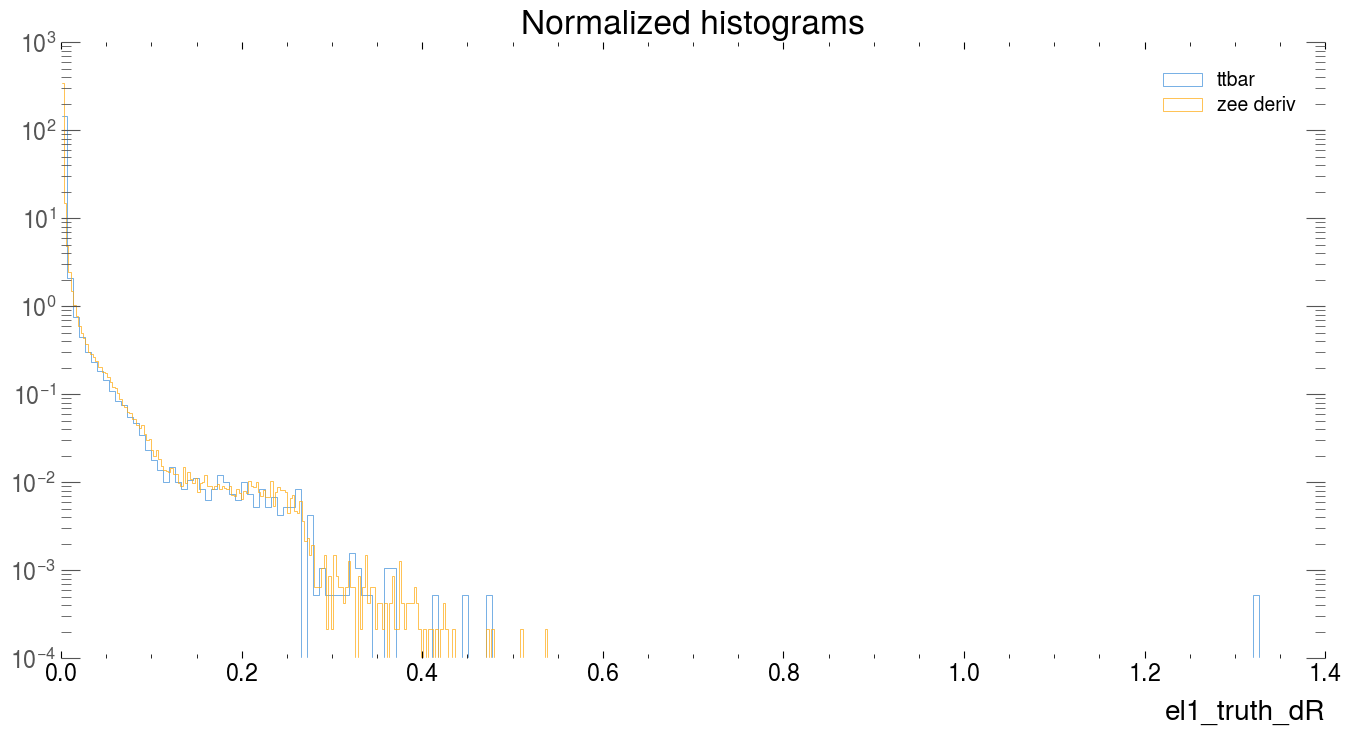

In [91]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(cut_data_ttbar['el1_truth_dR'],histtype='step',density=True,bins=200, label='ttbar')
ax.hist(cut_data_zeederiv['el1_truth_dR'],histtype='step',density=True,bins=200, label='zee deriv')
ax.set_title('Normalized histograms')
ax.set_yscale('log')
ax.set_xlabel('el1_truth_dR')
ax.legend()

In [92]:
# truth_filter = (0, 0.1)
# cut_data_ttbar = data_ttbar[(data_ttbar['el1_truth_dR'] >= truth_filter[0]) & (data_ttbar['el1_truth_dR'] <= truth_filter[1])]
# cut_data_zeederiv = data_zeederiv[(data_zeederiv['el1_truth_dR'] >= truth_filter[0]) & (data_zeederiv['el1_truth_dR'] <= truth_filter[1])]
# print(len(cut_data_ttbar)/len(data_ttbar))
# print(len(cut_data_zeederiv)/len(data_zeederiv))

In [93]:
print(data_zeederiv.columns)

Index(['event_index', 'el1_index', 'runNumber', 'eventNumber', 'eventTrigger',
       'actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'el1_pt', 'el1_eta', 'el1_phi', 'el1_m', 'el1_charge', 'el1_f1',
       'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_LHLoose',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_DFCommonElectronsLHVeryLoose',
       'el1_DFCommonElectronsLHVeryLooseIsEMValue',
       'el1_DFCommonElectronsDNN_pel', 'el1_DFCommonElectronsDNN_pcf',
       'el1_DFCommonElectronsDNN_ppc', 'el1_DFCommonElectronsDNN_phf',
       'el1_DFCommonElectronsDNN_ple', 'el1_DFCommonElectronsDNN_plh',
       'el1_GSFTrack_d0', 'el1_GSFTrack_z0', 'el1_GSFTrack_theta',
       'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP', 'el1_GSF_dR',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el1_GSF_Track_Var2',
       'el1_GSF_Track

15    30110.113281
49    54275.945312
58    41299.828125
Name: el1_truth_E, dtype: float64
15    28098.882812
49    54428.476562
58    50344.789062
Name: ATLAS_E, dtype: float32


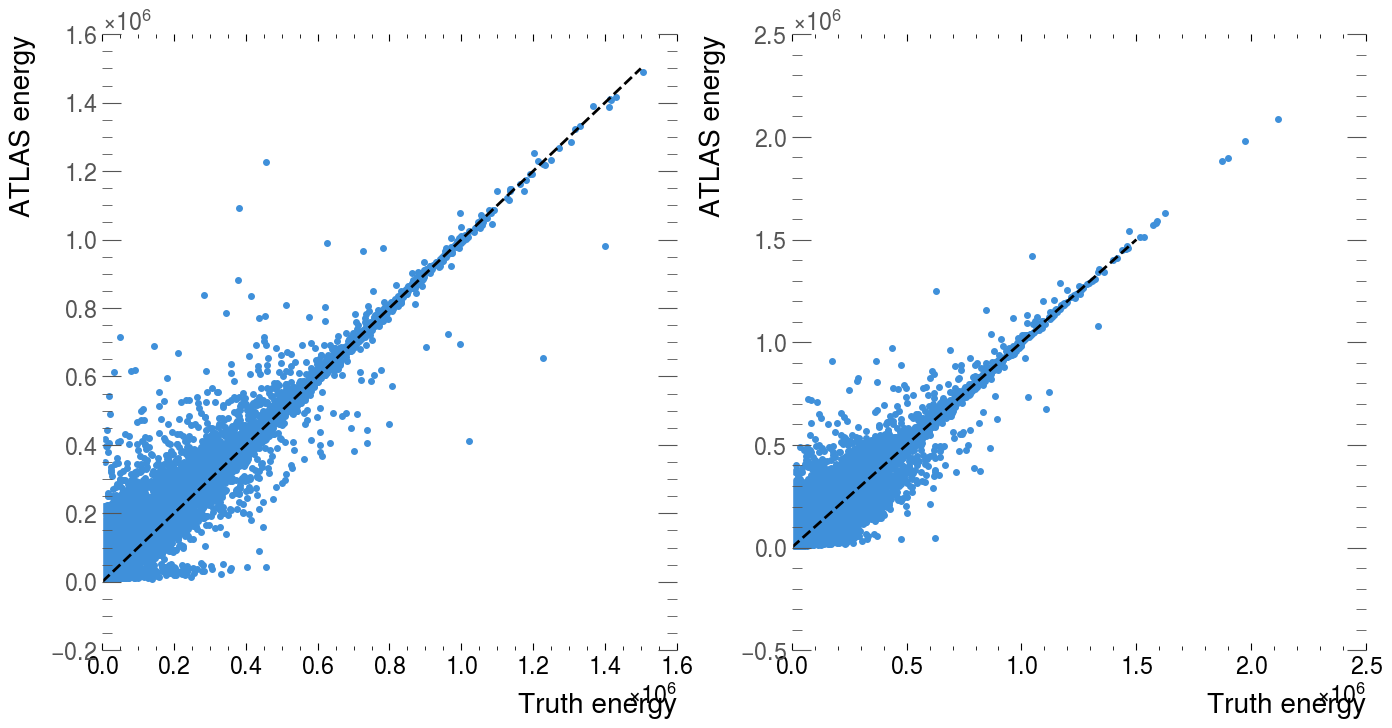

In [94]:
fig, ax = plt.subplots(1,2,figsize = (16, 8))
ax[0].plot(cut_data_ttbar['el1_truth_E'], cut_data_ttbar['ATLAS_E'], '.', label='zee deriv')
ax[0].plot([0, 1.5e6], [0, 1.5e6], 'k--')
ax[1].plot(cut_data_zeederiv['el1_truth_E'],cut_data_zeederiv['ATLAS_E'], '.', label='zee deriv')
ax[1].plot([0, 1.5e6], [0, 1.5e6], 'k--')
ax[0].set_xlabel('Truth energy')
ax[0].set_ylabel('ATLAS energy')
ax[1].set_xlabel('Truth energy')
ax[1].set_ylabel('ATLAS energy')
ax[0].set_title('ttbar')
ax[1].set_title('zee deriv')

print(cut_data_ttbar['el1_truth_E'].head(3))
print(cut_data_ttbar['ATLAS_E'].head(3))

In [95]:
param_list = ['ATLAS_E', 'el1_eta', 'el1_phi', 'el1_m', 'el1_charge', 'el1_f1',
       'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_LHLoose',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_DFCommonElectronsLHVeryLoose',
       'el1_DFCommonElectronsLHVeryLooseIsEMValue',
       'el1_DFCommonElectronsDNN_pel', 'el1_DFCommonElectronsDNN_pcf',
       'el1_DFCommonElectronsDNN_ppc', 'el1_DFCommonElectronsDNN_phf',
       'el1_DFCommonElectronsDNN_ple', 'el1_DFCommonElectronsDNN_plh',
       'el1_GSFTrack_d0', 'el1_GSFTrack_z0', 'el1_GSFTrack_theta',
       'el1_GSFTrack_phi', 'el1_GSF_dR',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el1_GSF_Track_Var2',
       'el1_GSF_Track_Var3', 'el1_GSF_Track_Var4', 'el1_ptvarcone20',
       'el1_topoetcone20', 'el1_topoetcone40',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_core57cellsEnergyCorrection', 'el1_topoetcone20ptCorrection',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500','el1_InDetTrack_d0', 'el1_InDetTrack_z0',
       'el1_InDetTrack_theta', 'el1_InDetTrack_phi', 'el1_InDetTrack_covdiag0',
       'el1_InDetTrack_covdiag1', 'el1_InDetTrack_covdiag2',
       'el1_InDetTrack_covdiag3', 'el1_InDetTrack_covdiag4', 'el1_InDet_dR', 'el1_egammaCluster_eta', 'el1_egammaCluster_phi',
       'el1_egammaClustersAuxDyn_calE', 'el1_egammaClustersAuxDyn_clusterSize',
       'el1_egammaClustersAuxDyn_altE', 'el1_egammaClustersAuxDyn_calM',
       'el1_egammaClustersAuxDyn_ETA2CALOFRAME',
       'el1_egammaClustersAuxDyn_ETACALOFRAME',
       'el1_egammaClustersAuxDyn_PHI2CALOFRAME',
       'el1_egammaClustersAuxDyn_PHICALOFRAME',
       'el1_GSFTrack_POverq', 'el1_InDetTrack_POverq']

param_list_small = ['ATLAS_E', 'el1_eta', 'el1_phi', 
       'el1_m', 'el1_charge', 'el1_f1','el1_egammaClustersAuxDyn_calE', 
       'el1_egammaClustersAuxDyn_clusterSize',
       'el1_egammaClustersAuxDyn_altE', 
       'el1_egammaClustersAuxDyn_calM',
       'el1_egammaClustersAuxDyn_ETA2CALOFRAME',
       'el1_egammaClustersAuxDyn_ETACALOFRAME',
       'el1_egammaClustersAuxDyn_PHI2CALOFRAME',
       'el1_egammaClustersAuxDyn_PHICALOFRAME',
       'el1_GSFTrack_POverq', 'el1_InDetTrack_POverq']

In [96]:
data = pd.concat([cut_data_zeederiv, cut_data_ttbar])#.reset_index(drop=True)
# data = cut_data_zeederiv
print(data.shape)
# data = data[data['el1_truth_E'] < 0.8e5]
print(data.shape)

print('Number of duplicate rows in data:', (data[['eventNumber','el1_index','event_index','runNumber',]]).duplicated().sum())
print('Number of duplicate dataframe indexes in data:', data.index.duplicated().sum())
# reset index
data = data.reset_index(drop=True)
print('Number of dubplicate dataframe indexes in data after reset:', data.index.duplicated().sum())
print(cut_data_ttbar.head(10).index)
print(cut_data_zeederiv.head(10).index)


# print((data[['eventNumber']])[(data[['eventNumber','el1_index']]).duplicated()==True].value_counts())

# print('-----')
# print(data[data['eventNumber']==8689997])

(2025174, 93)
(2025174, 93)
Number of duplicate rows in data: 0
Number of duplicate dataframe indexes in data: 183416
Number of dubplicate dataframe indexes in data after reset: 0
Index([15, 49, 58, 59, 62, 76, 97, 110, 115, 118], dtype='int64')
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


In [97]:



print(((data['eventNumber'] % 4)).value_counts())
# train = data[data['eventNumber'] % 4 != 0]
# test = data[data['eventNumber'] % 4 == 0]


train, test = train_test_split(data, test_size=0.25, random_state=1)

# train = data.sample(frac=0.75, random_state=13)
# test = data.drop(train.index)

print('train:', len(train), len(train)/(len(train) + len(test)))
print('test:', len(test), len(test)/(len(train) + len(test)))
print('ratio:', len(test)/len(train))

X_train = train[param_list]
y_train = train['el1_truth_E']

eventNumber
3    507257
2    506349
0    505928
1    505640
Name: count, dtype: int64
train: 1518880 0.7499997531076342
test: 506294 0.2500002468923658
ratio: 0.33333377225323924



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 20 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mae

     . Trial number: 0 finished
     .. Optimization score (lower-better): mae: 4032.416429794758
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mae: 4080.105425622711
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mae: 4028.136573774025
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mae: 4042.223675518319
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): mae: 4083.0855356725738
 ..........................................................

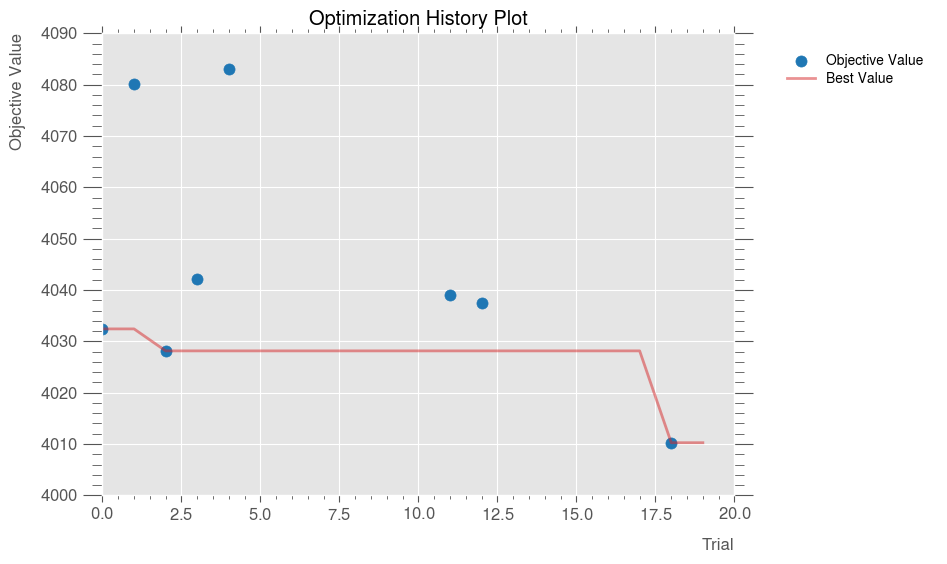

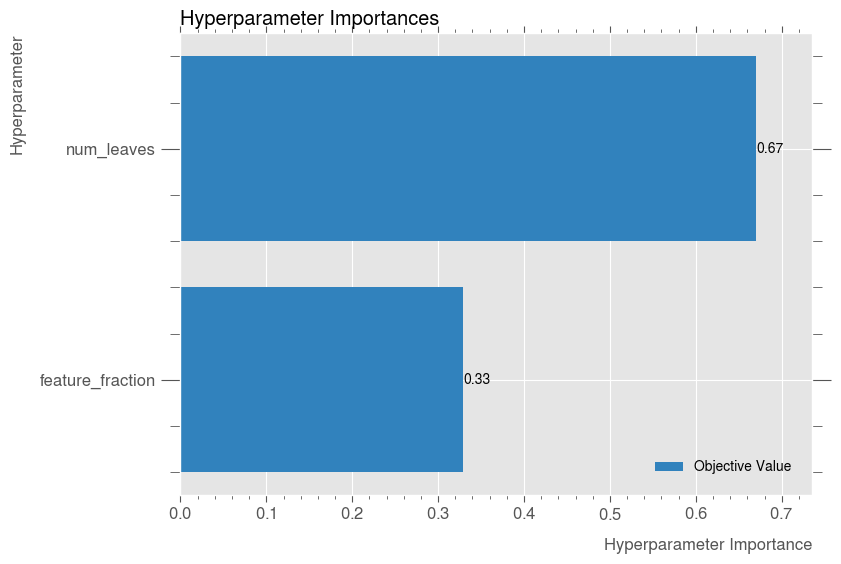

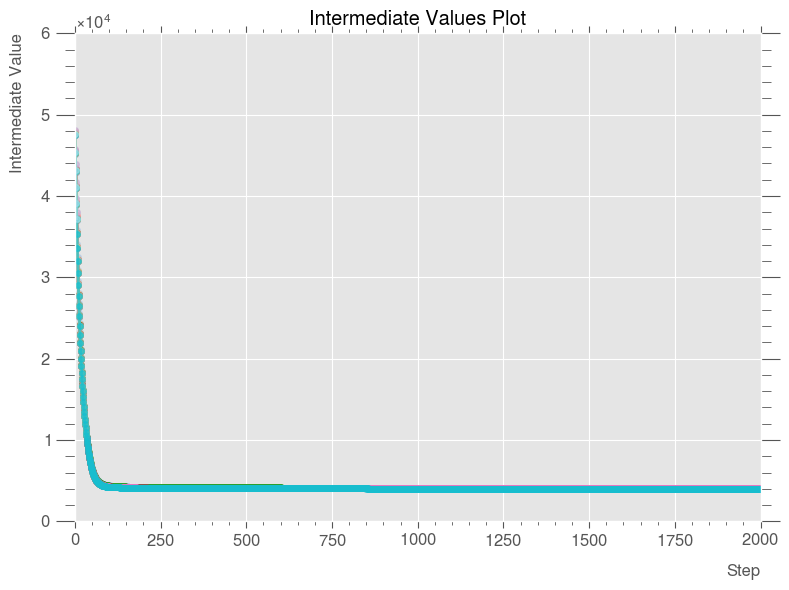

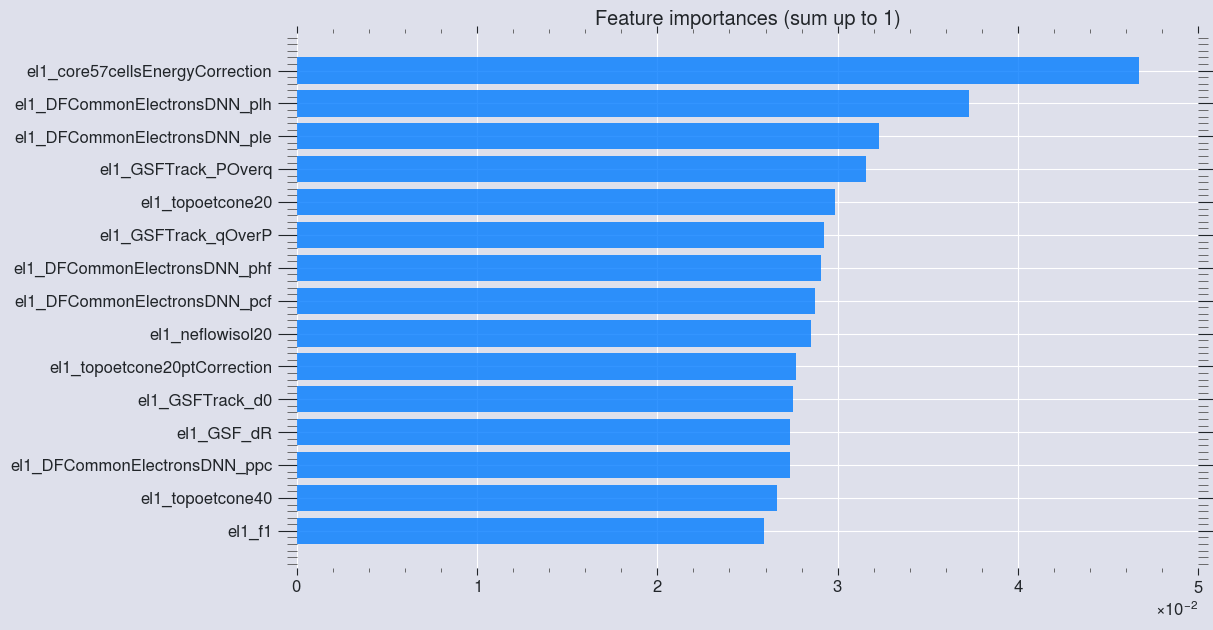


     . Optuna hyperparameters optimization finished
     .. Best trial number:18    |     mae:             4010.24410908834
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 15 min 48.134 sec

   - Fitting optimized model with the following params:
learning_rate                    : 0.05
num_leaves                       : 233
feature_fraction                 : 0.7807937450273171
bagging_fraction                 : 0.9
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l1
num_threads                      : 38
num_iterations                   : 1998


In [98]:
tuner = RapidGBMTuner(metric='mae', trials=20, refit=True, verbosity=1, visualization=True, seed=414243)
tuner.fit(X_train, y_train)

tuner.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())

In [109]:
tuner.best_params

{'learning_rate': 0.05,
 'num_leaves': 233,
 'feature_fraction': 0.7807937450273171,
 'bagging_fraction': 0.9,
 'verbosity': -1,
 'random_state': 42,
 'device_type': 'cpu',
 'objective': 'regression',
 'metric': 'l1',
 'num_threads': 38,
 'num_iterations': 1998}

no


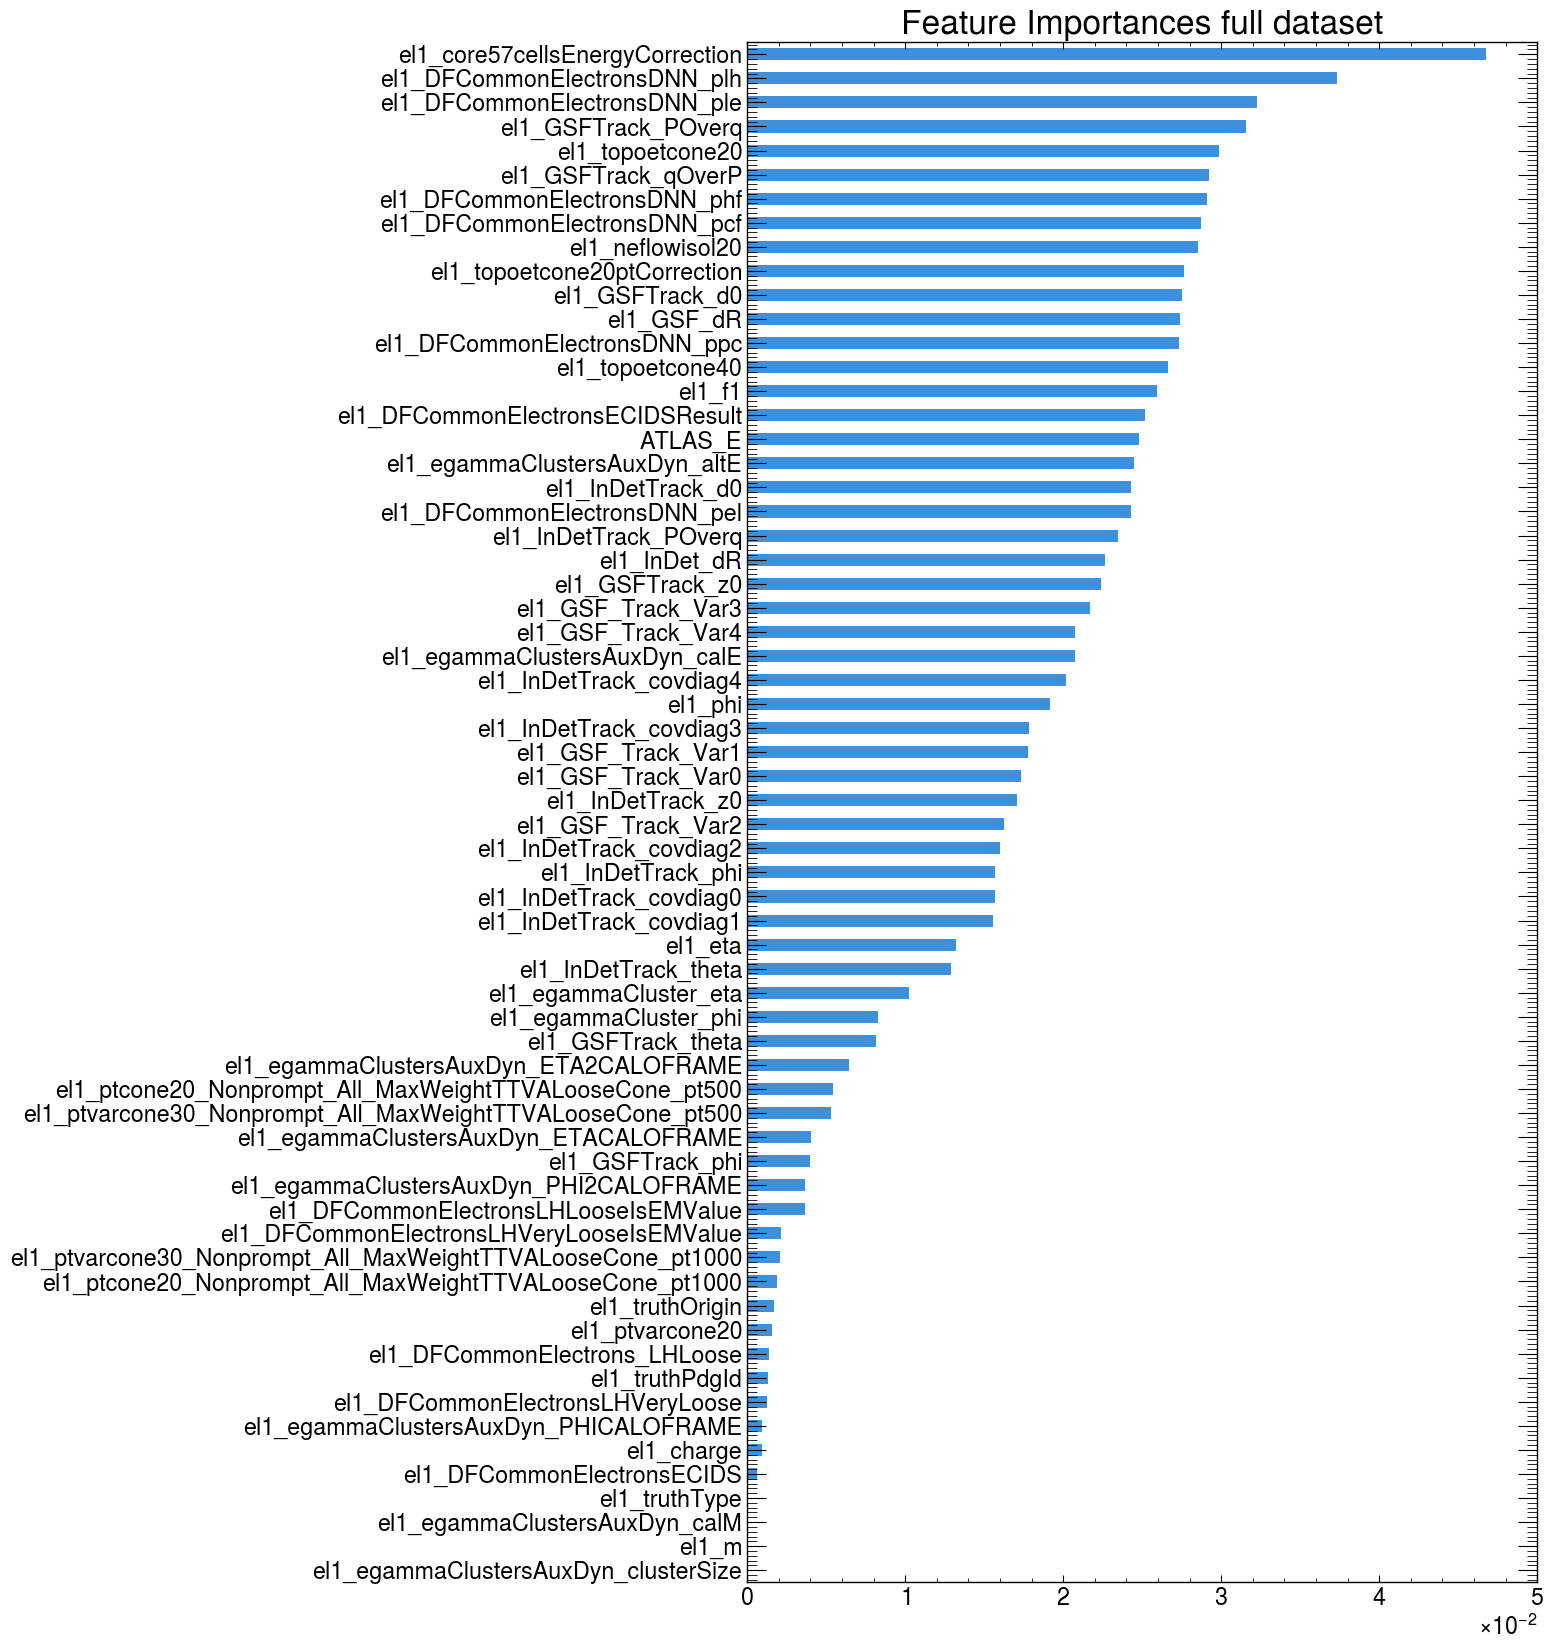

In [99]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 20))
ax.set_title('Feature Importances full dataset')
tuner.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

Text(0.5, 1.0, 'full dataset')

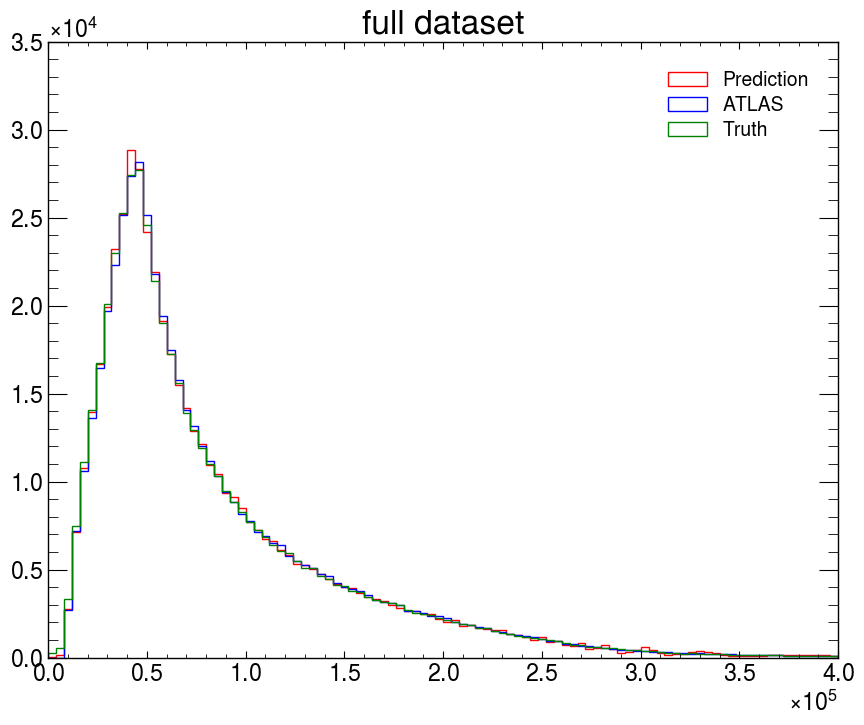

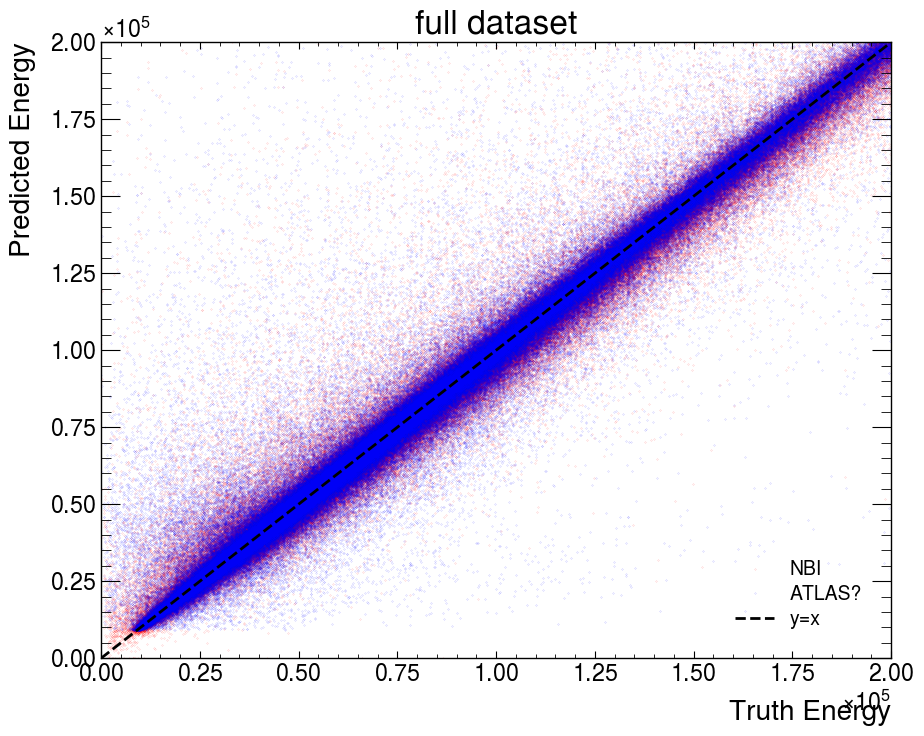

In [100]:
prediction = tuner.predict(test[param_list])

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(prediction, bins=100,range=(0,4e5), histtype='step', label='Prediction', color='red')
ax.hist(test['ATLAS_E'], bins=100,range=(0,4e5), histtype='step', label='ATLAS', color='blue')
ax.hist(test['el1_truth_E'], bins=100,range=(0,4e5), histtype='step', label='Truth', color='green')
# ax.hist(test['el1_pt'], bins=100, histtype='step', label='pt')
# ax.set_xscale('log')
ax.legend()
ax.set_title('full dataset')


fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(test['el1_truth_E'], prediction, '.',color='red',label='NBI', alpha=0.5, ms=0.3)
ax.plot(test['el1_truth_E'], test['ATLAS_E'],'.', color='blue',label='ATLAS?', alpha=0.5, ms=0.3)
ax.plot([0, 1e6], [0, 1e6], 'k--', label='y=x')
ax.set_ylim(0, 0.2e6)
ax.set_xlim(0, 0.2e6)
ax.legend()
ax.set_xlabel('Truth Energy')
ax.set_ylabel('Predicted Energy')
ax.set_title('full dataset')



no


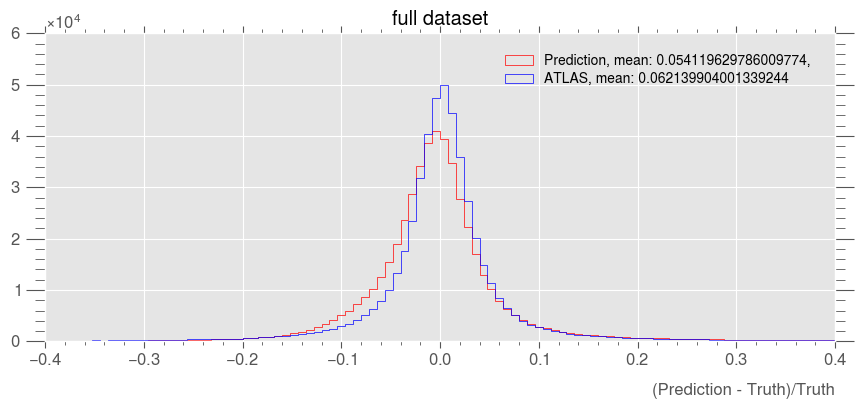

In [114]:

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist((prediction - test['el1_truth_E'])/test['el1_truth_E'],range=(-0.4,0.4), bins=100, histtype='step', label=f'Prediction, mean: {np.mean((prediction - test['el1_truth_E'])/test['el1_truth_E'])}, ', color='red')
ax.hist((test['ATLAS_E'] - test['el1_truth_E'])/test['el1_truth_E'],range=(-0.4,0.4), bins=100, histtype='step', label=f'ATLAS, mean: {np.mean((test['ATLAS_E'] - test['el1_truth_E'])/test['el1_truth_E'])}', color='blue')
ax.legend()
ax.set_xlabel('(Prediction - Truth)/Truth')
ax.set_title('full dataset')


print('no')

no


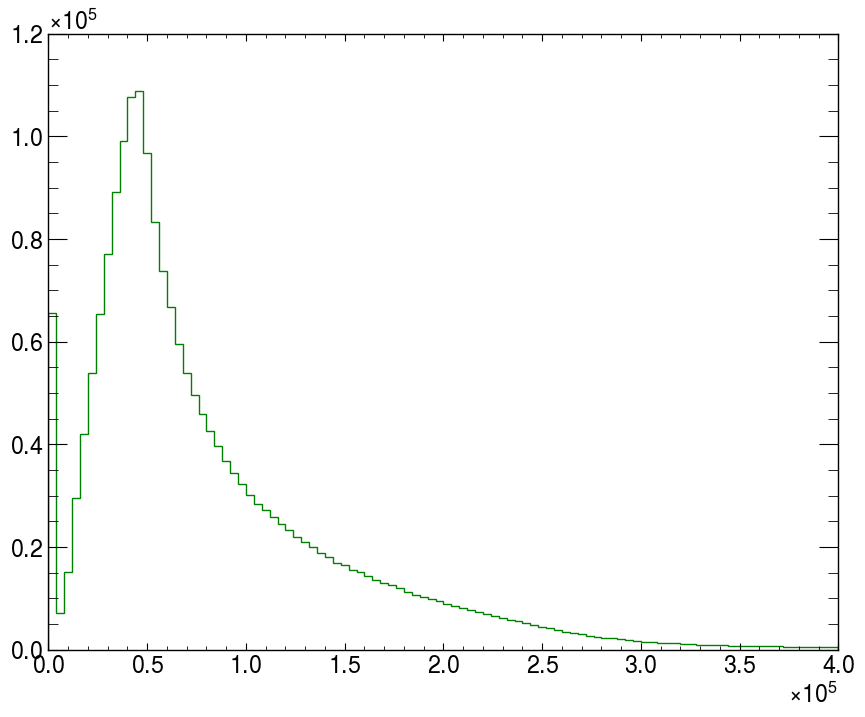

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(data_zeederiv['el1_truth_E'], bins=100,range=(0,4e5), histtype='step', label='Truth', color='green')


print('no')

In [103]:
print(tuner.feature_importances.sort_values().index[10:-1])

Index(['el1_ptvarcone20', 'el1_truthOrigin',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_DFCommonElectronsLHVeryLooseIsEMValue',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_egammaClustersAuxDyn_PHI2CALOFRAME', 'el1_GSFTrack_phi',
       'el1_egammaClustersAuxDyn_ETACALOFRAME',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_egammaClustersAuxDyn_ETA2CALOFRAME', 'el1_GSFTrack_theta',
       'el1_egammaCluster_phi', 'el1_egammaCluster_eta',
       'el1_InDetTrack_theta', 'el1_eta', 'el1_InDetTrack_covdiag1',
       'el1_InDetTrack_covdiag0', 'el1_InDetTrack_phi',
       'el1_InDetTrack_covdiag2', 'el1_GSF_Track_Var2', 'el1_InDetTrack_z0',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el1_InDetTrack_covdiag3',
       'el1_phi', 'el1_InDetTrack_covdiag4', 'el1_egammaCl

In [104]:
# # save model
# import pickle
# with open('E_model_BDT_ttbar_Zeederiv_1Oct.pkl', 'wb') as file: #bdt_MC_HZg_mumu_1s02bkg_100ep_23Sept
#     pickle.dump(tuner, file)
# with open('E_model_BDT_ttbar_Zeederiv_variables_1Oct_variables.pkl', 'wb') as fp:
#     pickle.dump(param_list, fp)

In [105]:



print(((data['eventNumber'] % 4)).value_counts())
# train = data[data['eventNumber'] % 4 != 0]
# test = data[data['eventNumber'] % 4 == 0]


train, test = train_test_split(data, test_size=0.25, random_state=1)

# train = data.sample(frac=0.75, random_state=13)
# test = data.drop(train.index)

print('train:', len(train), len(train)/(len(train) + len(test)))
print('test:', len(test), len(test)/(len(train) + len(test)))
print('ratio:', len(test)/len(train))

X_train = train[param_list_small]
y_train = train['el1_truth_E']

eventNumber
3    507257
2    506349
0    505928
1    505640
Name: count, dtype: int64
train: 1518880 0.7499997531076342
test: 506294 0.2500002468923658
ratio: 0.33333377225323924



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 10 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mae

     . Trial number: 0 finished
     .. Optimization score (lower-better): mae: 4842.540477220505
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mae: 4795.9243227559045
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mae: 4792.226330833759
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mae: 4804.747848655469
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): mae: 4818.837928546859
 ..........................................................

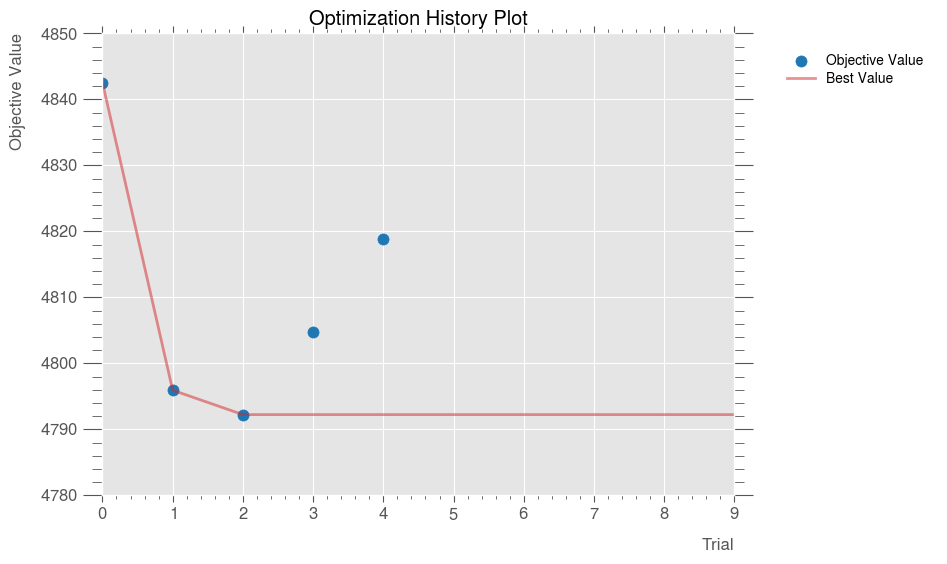

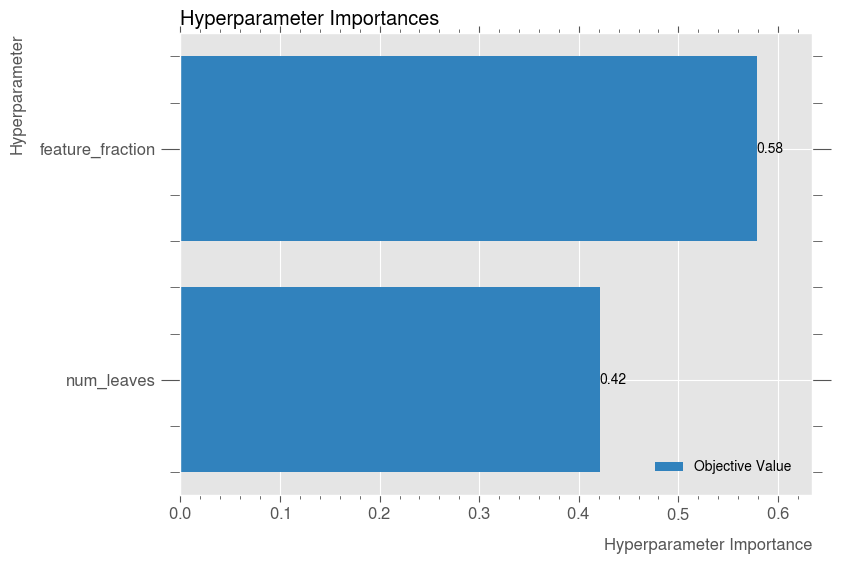

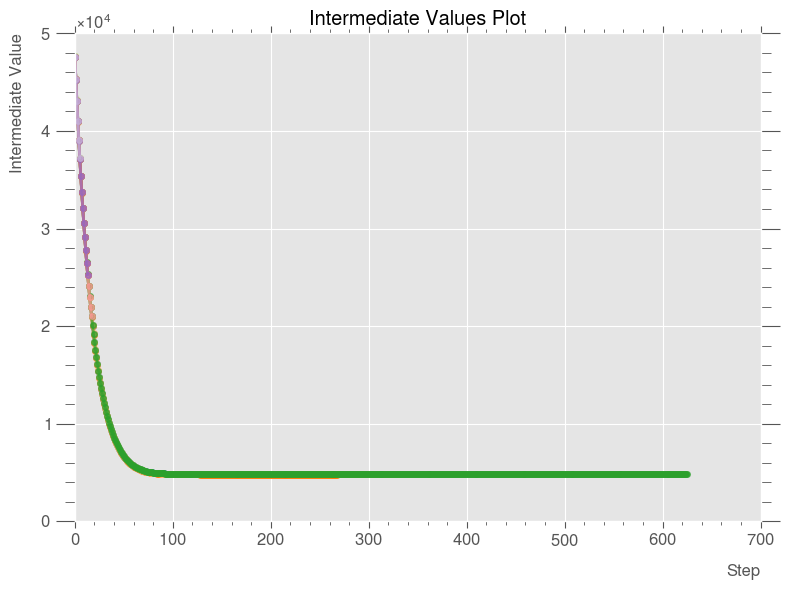

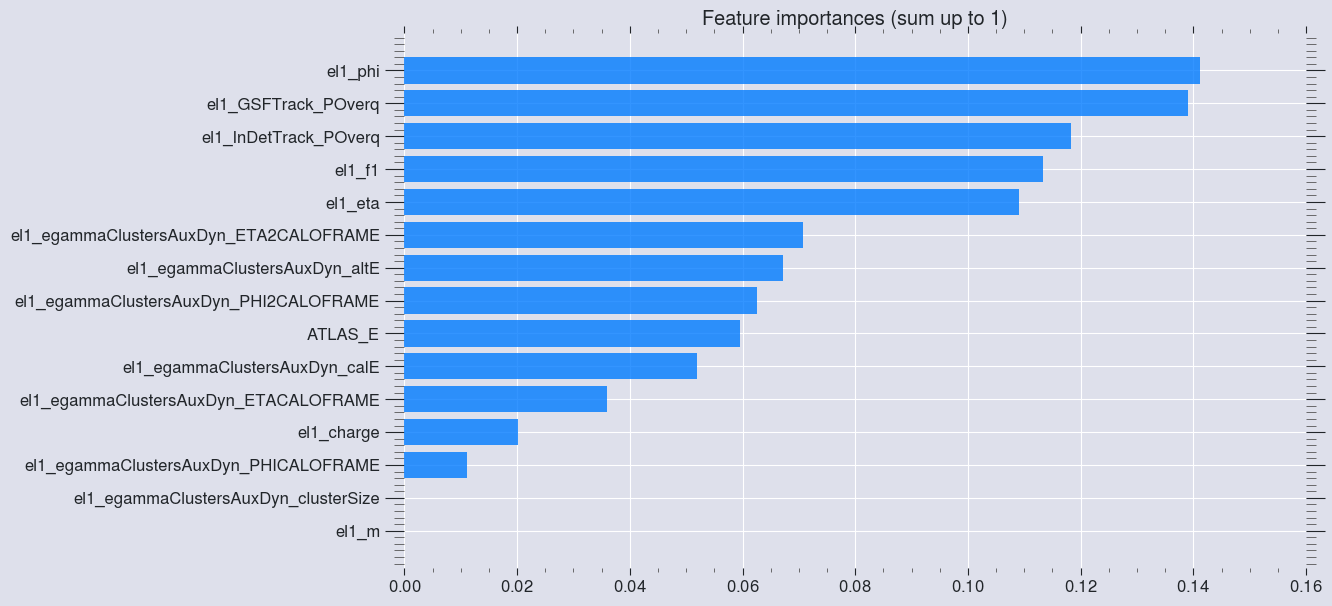


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     mae:            4792.226330833759
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 1 min 9.51 sec

   - Fitting optimized model with the following params:
learning_rate                    : 0.05
num_leaves                       : 222
feature_fraction                 : 0.8525217054365005
bagging_fraction                 : 0.9
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l1
num_threads                      : 38
num_iterations                   : 169


In [106]:
tuner_small = RapidGBMTuner(metric='mae', trials=10, refit=True, verbosity=1, visualization=True, seed=414243)
tuner_small.fit(X_train, y_train)

tuner_small.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())

Text(0.5, 1.0, 'full dataset')

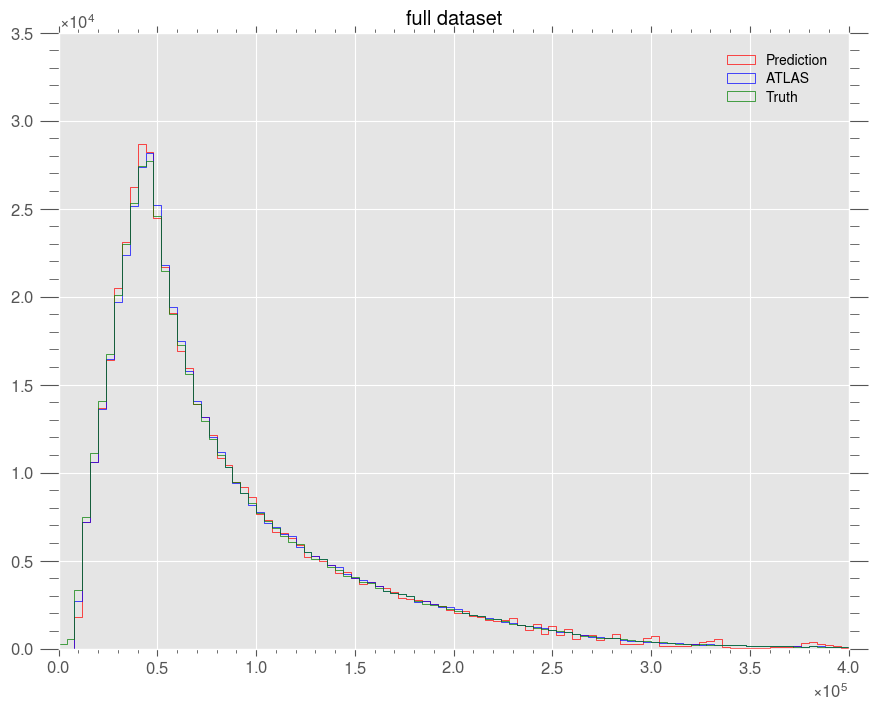

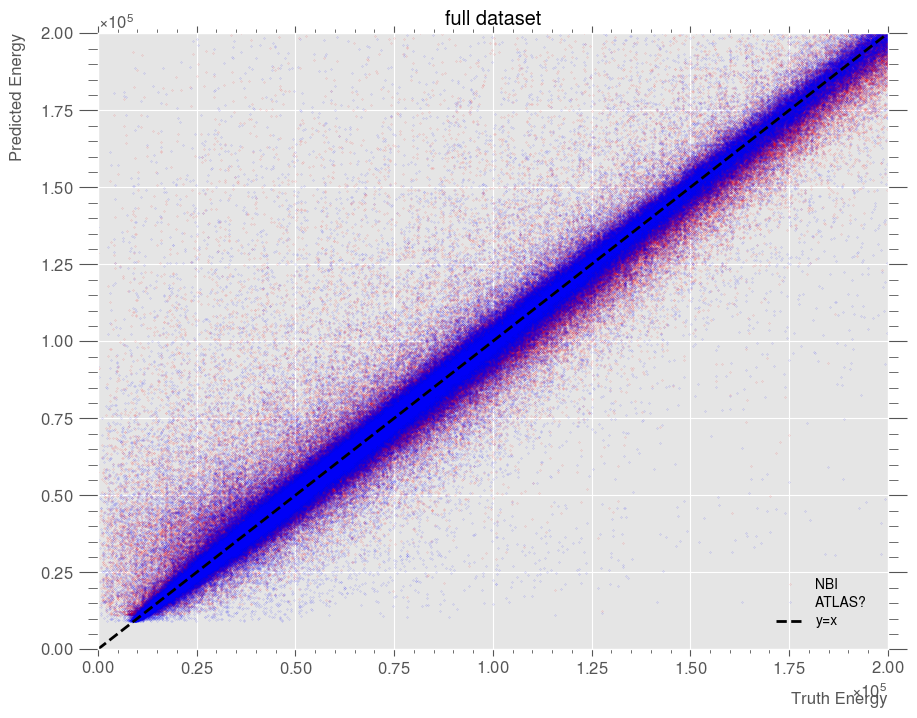

In [107]:
prediction = tuner_small.predict(test[param_list_small])

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(prediction, bins=100,range=(0,4e5), histtype='step', label='Prediction', color='red')
ax.hist(test['ATLAS_E'], bins=100,range=(0,4e5), histtype='step', label='ATLAS', color='blue')
ax.hist(test['el1_truth_E'], bins=100,range=(0,4e5), histtype='step', label='Truth', color='green')
# ax.hist(test['el1_pt'], bins=100, histtype='step', label='pt')
# ax.set_xscale('log')
ax.legend()
ax.set_title('full dataset')


fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(test['el1_truth_E'], prediction, '.',color='red',label='NBI', alpha=0.5, ms=0.3)
ax.plot(test['el1_truth_E'], test['ATLAS_E'],'.', color='blue',label='ATLAS?', alpha=0.5, ms=0.3)
ax.plot([0, 1e6], [0, 1e6], 'k--', label='y=x')
ax.set_ylim(0, 0.2e6)
ax.set_xlim(0, 0.2e6)
ax.legend()
ax.set_xlabel('Truth Energy')
ax.set_ylabel('Predicted Energy')
ax.set_title('full dataset')



no


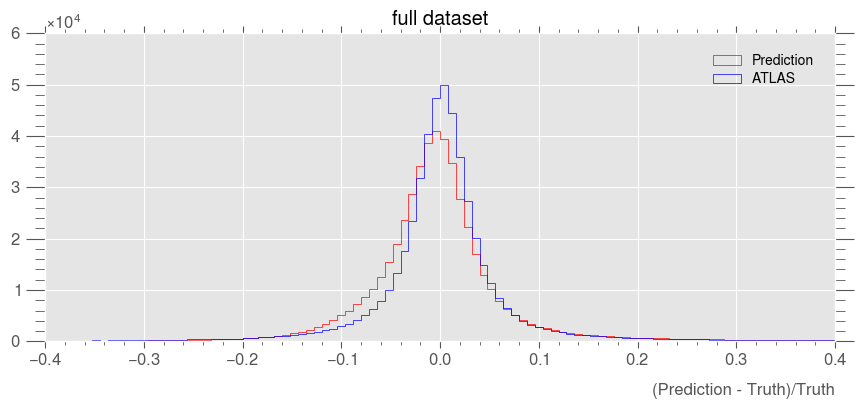

In [108]:

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist((prediction - test['el1_truth_E'])/test['el1_truth_E'],range=(-0.4,0.4), bins=100, histtype='step', label='Prediction', color='red')
ax.hist((test['ATLAS_E'] - test['el1_truth_E'])/test['el1_truth_E'],range=(-0.4,0.4), bins=100, histtype='step', label='ATLAS', color='blue')
ax.legend()
ax.set_xlabel('(Prediction - Truth)/Truth')
ax.set_title('full dataset')


print('no')